<center>

### COSC2753 - Machine Learning

# **Model Development - Convolutional Neural Network (CNN)**

<center>────────────────────────────</center>
&nbsp;


# I. Introduction

In this notebook, we will focus on the development of a Convolutional Neural Network (CNN) model. This process will involve training the CNN model on preprocessed image data and optimizing its performance through hyperparameter tuning. Specifically, we will perform the following steps:

- **Training:** We will train the selected CNN model using the preprocessed image data. This involves feeding the data into the model and adjusting its parameters to minimize the loss function.

- **Hyperparameter Tuning:** We will explore different combinations of hyperparameters to optimize the performance of our CNN model. This may include tuning parameters such as learning rate, batch size, and regularization strength.

- **Model Evaluation:** After training and tuning the CNN model, we will evaluate its performance using appropriate evaluation metrics. This step will help us assess how well the model generalizes to unseen data and determine its effectiveness in predicting labels for new images in the dataset.

By the end of this notebook, we will have developed a well-trained CNN model and evaluated its performance, providing insights into its effectiveness for image recognition tasks. This model will serve as a foundation for further analysis and applications in image classification.

# II. Importing Libraries

In [2]:
import os  # OS related functions
import numpy as np  # Numerical functions
import pandas as pd  # Data manipulation
import matplotlib.pyplot as plt  # Plotting
import seaborn as sns  # Plotting

# Deep learning
import tensorflow as tf
from keras.models import Sequential  # Pipeline
from keras.layers import (
    Dense,
    Conv2D,
    Flatten,
    MaxPooling2D,
    BatchNormalization,
    Dropout,
)  # Layers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau  # Callbacks
from tensorflow.keras.preprocessing.image import (
    ImageDataGenerator,
)  # Image data generator
from tensorflow.keras.optimizers import Adam

# Sklearn
from sklearn.metrics import classification_report  # Metrics
from sklearn.utils.class_weight import compute_class_weight  # Class weights
from sklearn.model_selection import train_test_split

print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

2024-05-17 09:06:36.031098: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-17 09:06:36.031147: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-17 09:06:36.032150: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-17 09:06:36.037323: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-17 09:06:36.696188: W tensorflow/compiler/tf2

GPU is available


2024-05-17 09:06:37.906605: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-17 09:06:37.928978: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-17 09:06:37.929261: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


# III. Data Loading and Preprocessing

Following the data preprocessing steps, we have split the raw image directory into training and validation sets. We will now load the preprocessed image data and prepare it for training the CNN model.

In [3]:
image_size = 256  # Image size

df_train = pd.read_csv("../../data/processed/train.csv") # Load train data
df_test = pd.read_csv("../../data/test/test.csv") # Load test data

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196626 entries, 0 to 196625
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Path      196626 non-null  object 
 1   Category  196626 non-null  object 
 2   Style     196626 non-null  object 
 3   Width     196626 non-null  int64  
 4   Height    196626 non-null  int64  
 5   MinValue  196626 non-null  int64  
 6   MaxValue  196626 non-null  int64  
 7   StdDev    196626 non-null  float64
dtypes: float64(1), int64(4), object(3)
memory usage: 12.0+ MB


In [4]:
#convert \ to / in path
df_train["Path"] = df_train["Path"].str.replace("\\", "/")
df_test["Path"] = df_test["Path"].str.replace("\\", "/")

df_train.head()

,Path,Category,Style,Width,Height,MinValue,MaxValue,StdDev
0,../../data/raw/Furniture_Data/Furniture_Data/d...,dressers,Asian,256,256,0,255,78.264032
1,../../data/raw/Furniture_Data/Furniture_Data/l...,lamps,Asian,256,256,0,255,56.407194
2,../../data/raw/Furniture_Data/Furniture_Data/d...,dressers,Asian,256,256,0,255,69.652896
3,../../data/raw/Furniture_Data/Furniture_Data/l...,lamps,Asian,256,256,5,255,84.765229
4,../../data/raw/Furniture_Data/Furniture_Data/l...,lamps,Asian,256,256,2,255,56.764965


At this step, we will perform the following tasks:

- **Data Loading:** Load the preprocessed image data from the training and validation directories.
- **Data Normalization:** Normalize the pixel values of the images to a range of `[0, 1]`.
- **Convert Image Path to Image Data:** Convert the image paths to image data arrays for training the CNN model.

For the conversion of image paths to image data arrays, we will use the [`ImageDataGenerator`](https://keras.io/api/preprocessing/image/) class from the Keras library. This class provides a flexible way to load and preprocess image data for training deep learning models. Moreover, we also utilize the **batch size** parameter to specify the number of samples processed in each training iteration. This parameter can impact the training speed and model performance, and we will explore different batch sizes during hyperparameter tuning.

As suggested in the literature, a batch size of `32` is commonly used for training CNN models. However, we will experiment with different batch sizes to determine the optimal value for our model.

[Supporting document on how to choose a batch size](https://medium.com/data-science-365/determining-the-right-batch-size-for-a-neural-network-to-get-better-and-faster-results-7a8662830f15#:~:text=It%20is%20a%20good%20practice,requires%20fewer%20epochs%20to%20converge)


In [5]:
# Image data generator
datagen = ImageDataGenerator(rescale=1.0 / 255)

# Separate the test dataset for validation
df_val, df_test = train_test_split(df_test, test_size=0.3, random_state=42)

batch_size = 32  # Number of samples per gradient update
num_classes = df_train["Category"].nunique()  # Number of classes

# Image data generator
datagen = ImageDataGenerator(rescale=1.0 / 255)

# Common arguments
common_args = {
    "x_col": "Path",  # Path to image
    "y_col": "Category",  # Target column
    "batch_size": batch_size,  # Batch size
    "class_mode": "categorical",  # Class mode
    "target_size": (image_size, image_size),  # Specify the target image size
}

# Create generator for training data
train_dataset = datagen.flow_from_dataframe(
    dataframe=df_train,  # Training data
    shuffle=True,  # Shuffle the data
    **common_args  # Common arguments
)

# Create generator for testing data
val_dataset = datagen.flow_from_dataframe(
    dataframe=df_val,  # Testing data
    shuffle=False,  # Do not shuffle the data
    **common_args  # Common arguments
)

Found 196626 validated image filenames belonging to 6 classes.
Found 11475 validated image filenames belonging to 6 classes.


In [6]:
labels = {value: key for key, value in train_dataset.class_indices.items()}

print("Label Mappings for different categories:")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for different categories:
0 : beds
1 : chairs
2 : dressers
3 : lamps
4 : sofas
5 : tables


# III. Model Development (CNN)

## CNN Model Architecture Initialization

For this part, we will initialize the CNN model architecture by defining the layers and parameters of the model. The CNN model will consist of the following layers:

- **Convolutional Layers:** These layers apply convolution operations to the input data, extracting features from the images. We can specify the number of filters, kernel size, activation function, and padding for each convolutional layer.

- **Pooling Layers:** Pooling layers downsample the feature maps generated by the convolutional layers, reducing the spatial dimensions of the data. We can choose the pooling type (e.g., max pooling, average pooling) and the pool size for each pooling layer.

- **Flattening Layer:** This layer flattens the output from the previous layers into a one-dimensional array, preparing the data for the fully connected layers.

- **Fully Connected Layers:** These layers process the flattened data, learning the patterns and relationships in the image features. We can specify the number of neurons and activation functions for each fully connected layer.

- **Output Layer:** The output layer produces the final predictions of the model. For multi-class classification tasks, we typically use the softmax activation function and set the number of units to the number of classes in the dataset.

For the choice of values for the hyperparameters, we will consider the following guidelines:

- **Number of Convolutional Layers:** [`1`] It is suggested that deeper networks with more convolutional layers can capture more complex features in the data. However, adding too many layers can lead to overfitting, so we need to find the right balance. Hence, we opt for the value of `3-5` convolutional layers, which is suitable for most image classification tasks while maintaining model efficiency and time complexity.

- **Size of Filters (Kernel Size):** In convolutional neural networks (CNNs), the size of the filter, also known as the kernel size, plays a crucial role in the model's ability to extract different features from the data. Common filter sizes include `3x3` and `5x5`. These sizes are effective at capturing localized patterns within images. Studies, such as the work by A. Ihare [`2`], suggest that a filter size of `3x3` is a popular choice for many CNN architectures. This preference stems from the fact that the number of parameters in a CNN increases rapidly as the kernel size grows. Larger kernels, while potentially capturing more complex features, can become computationally expensive and inefficient. Therefore, we will use a filter size of `3x3` for our CNN model.

- **Pooling Layers:** Pooling layers are used to downsample the feature maps generated by the convolutional layers, reducing the spatial dimensions of the data. Common pooling types include max pooling and average pooling. Max pooling is often preferred for its ability to retain the most important features in the data. We will use max pooling layers with a pool size of `2x2`, which is a common choice in CNN architectures [`3`].

- **Dropout Layers:** [`4`] Dropout layers are used to prevent overfitting by randomly setting a fraction of input units to zero during training. This regularization technique helps the model generalize better to unseen data. Based on the research and experiments conducted in [`4`], CNN gives the best overall performance when using dropout layers with a dropout rate of `0.2` for convolutional layers and `0.5` for fully connected layers. We will incorporate dropout layers with these dropout rates in our CNN model.

- **Activation Function:** One crucial factor influencing the performance of a **Convolutional Neural Network** (CNN) model is the selection of its activation function. Several commonly used activation functions include ReLU (Rectified Linear Unit), Leaky ReLU, ELU (Exponential Linear Unit), and Sigmoid. Research has further demonstrated that ReLU delivers the best performance specifically within CNN architectures [`5`]. Consequently, to optimize the convolutional and fully connected layers of our CNN model, we will employ the ReLU activation function.

In addition to the layers, we will also define the hyperparameters of the model, such as the **learning rate**, **optimizer**, **loss function**, and **metrics**. These parameters play a crucial role in training the CNN model and optimizing its performance.

**References:**

[1 - Convolutional Layers](https://www.linkedin.com/pulse/choosing-number-hidden-layers-neurons-neural-networks-sachdev/)

[2 - Size of Kernel](https://medium.com/analytics-vidhya/significance-of-kernel-size-200d769aecb1#:~:text=Limiting%20the%20number%20of%20parameters,size%20at%203x3%20or%205x5.)

[3 - Pooling Layers](https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/)

[4 - Dropout Layers](https://nchlis.github.io/2017_08_10/page.html)

[5 - Activation Functions](https://thangasami.medium.com/cnn-and-ann-performance-with-different-activation-functions-like-relu-selu-elu-sigmoid-gelu-etc-c542dd3b1365)



In [6]:
def create_cnn():
    cnn = Sequential()  # Pipeline

    # Convolutional layer 1
    cnn.add(
        Conv2D(
            32,
            kernel_size=(3, 3),
            activation="relu",
            input_shape=(image_size, image_size, 3),
            padding="same",
        )
    )
    cnn.add(MaxPooling2D(pool_size=(2, 2)))  # Max pooling
    cnn.add(BatchNormalization())  # Batch normalization
    cnn.add(Dropout(0.2))  # Dropout

    # Convolutional layer 2
    cnn.add(Conv2D(64, kernel_size=(3, 3), activation="relu"))  # Convolutional layer
    cnn.add(MaxPooling2D(pool_size=(2, 2)))  # Max pooling
    cnn.add(BatchNormalization())  # Batch normalization
    cnn.add(Dropout(0.2))  # Dropout

    # Convolutional layer 3
    cnn.add(Conv2D(128, kernel_size=(3, 3), activation="relu"))  # Convolutional layer
    cnn.add(MaxPooling2D(pool_size=(2, 2)))  # Max pooling
    cnn.add(BatchNormalization())  # Batch normalization
    cnn.add(Dropout(0.2))  # Dropout

    # Convolutional layer 4
    cnn.add(Conv2D(256, kernel_size=(3, 3), activation="relu"))  # Convolutional layer
    cnn.add(MaxPooling2D(pool_size=(2, 2)))  # Max pooling
    cnn.add(BatchNormalization())  # Batch normalization
    cnn.add(Dropout(0.2))  # Dropout

    cnn.add(Flatten())  # Flatten

    cnn.add(Dense(512, activation="relu"))  # Dense layer
    cnn.add(Dropout(0.2))  # Dropout
    cnn.add(Dense(256, activation="relu"))  # Dense layer
    cnn.add(Dropout(0.2))  # Dropout

    cnn.add(Dense(num_classes, activation="softmax"))  # Output layer

    cnn.summary()  # Model summary

    return cnn


cnn = create_cnn()  # Create CNN

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 128, 128, 32)      128       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 128, 128, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 63, 63, 64)        0

2024-05-15 17:46:17.803558: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-15 17:46:17.803850: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-15 17:46:17.804059: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-15 17:46:17.909827: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-15 17:46:17.910072: I external/local_xla/xla/stream_executor

## Training the CNN Model

### Addressing Class Imbalance

Our training data exhibits **class imbalance**, with certain classes having significantly fewer examples compared to others. To tackle this challenge and enhance model performance for minority classes, we'll leverage the `class_weight` parameter within the `fit()` function. This parameter allows us to assign weights to each class based on their frequency in the data. By assigning higher weights to underrepresented classes, the model will prioritize learning from these examples during training.

While other techniques exist for handling imbalanced data, we opted against specific approaches due to limitations in our project:

- **Oversampling:** This method involves acquiring additional images online to increase the number of minority class examples. However, due to the specialized domain of our project and the inherent similarity within categories, there's no guarantee that these additional images would possess the correct style relevant to our task.

- **Undersampling:** This approach involves removing data points from the majority class to achieve a more balanced distribution. However, in deep learning, having a larger dataset generally leads to better performance. Removing data could potentially hinder the model's learning capabilities.

### Additional Training Techniques

- **Early Stopping:** To prevent overfitting and optimize generalization, we will utilize **Early Stopping**. This technique monitors the validation loss during training and halts the training process if the validation loss fails to improve for a predefined number of epochs. This approach helps us avoid training for too long, which can lead to the model memorizing the training data instead of learning generalizable patterns.

- **Reduce Learning Rate on Plateau:** We will also implement a learning rate decay strategy using the **ReduceLROnPlateau** callback from Keras. This technique dynamically adjusts the learning rate during training. If the validation loss stops decreasing for a specified number of epochs (plateau), the learning rate is reduced by a predefined factor. This helps the model converge faster and potentially achieve better results by preventing it from getting stuck in local minima.



In [7]:
# Early stopping
early_stopping = EarlyStopping(
    monitor="val_loss",  # Monitor validation loss
    patience=5,  # Stop training if no improvement for 5 epochs
    restore_best_weights=True,  # Restore the best weights when stopping
    min_delta=0.001,  # Minimum change to qualify as an improvement
    verbose=1,  # Print messages
)

# Reduce learning rate
reduce_lr = ReduceLROnPlateau(
    monitor="val_accuracy",  # Monitor validation loss
    patience=5,  # Reduce learning rate if no improvement for 3 epochs
    factor=0.5,  # Factor by 0.5
    min_lr=0.00001,  # Minimum learning rate
    verbose=1,  # Print messages
)

# Calculate class weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(df_train["Category"]),
    y=df_train["Category"],
)

optimizer = Adam(learning_rate=0.0001)

# Convert class weights to dictionary
class_weight_dict = dict(enumerate(class_weights))

# Compile the model
cnn.compile(
    optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
)  # Compile model

# CSV logger
csv_logger = tf.keras.callbacks.CSVLogger(
    "./cache_cnn/training.csv", separator=",", append=False
)  # CSV logger

In [8]:
cnn.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=32,  # 10 epochs
    callbacks=[reduce_lr, early_stopping, csv_logger],
    class_weight=class_weight_dict,
    verbose=1,
)  # Fit model

Epoch 1/32


2024-05-15 17:46:19.470018: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-05-15 17:46:19.737244: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-05-15 17:46:19.911197: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-15 17:46:20.155196: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 646.01MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-15 17:46:20.353375: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 646.01MiB w

6145/6145 [==============================] - 889s 142ms/step - loss: 0.9053 - accuracy: 0.6853 - val_loss: 0.4722 - val_accuracy: 0.8360 - lr: 1.0000e-04
Epoch 2/32
6145/6145 [==============================] - 870s 142ms/step - loss: 0.5516 - accuracy: 0.8015 - val_loss: 0.2702 - val_accuracy: 0.9097 - lr: 1.0000e-04
Epoch 3/32
6145/6145 [==============================] - 866s 141ms/step - loss: 0.3972 - accuracy: 0.8540 - val_loss: 0.5840 - val_accuracy: 0.7996 - lr: 1.0000e-04
Epoch 4/32
6145/6145 [==============================] - 866s 141ms/step - loss: 0.2929 - accuracy: 0.8890 - val_loss: 0.2626 - val_accuracy: 0.9247 - lr: 1.0000e-04
Epoch 5/32
6145/6145 [==============================] - 866s 141ms/step - loss: 0.2191 - accuracy: 0.9136 - val_loss: 0.1840 - val_accuracy: 0.9451 - lr: 1.0000e-04
Epoch 6/32
6145/6145 [==============================] - 865s 141ms/step - loss: 0.1697 - accuracy: 0.9318 - val_loss: 0.2115 - val_accuracy: 0.9359 - lr: 1.0000e-04
Epoch 7/32
6145/6145 

In [9]:
cnn.save("./cache_cnn/cnn.keras")  # Save model
print(f"Model saved to ./cache_cnn/model.keras")

cnn.save_weights("./cache_cnn/weights_cnn.keras")  # Save weights
print(f"Weights saved to ./cache_cnn/weights.keras")

cnn.save("tmp", overwrite=True, include_optimizer=True, save_format=None, signatures=None, options=None)

/home/mudoker/anaconda3/envs/py31/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to ./cache_cnn/model.h5
Weights saved to ./cache_cnn/weights.h5
INFO:tensorflow:Assets written to: ./cache_cnn/cnn/assets


INFO:tensorflow:Assets written to: ./cache_cnn/cnn/assets


## Model Evaluation

In [11]:
# Evaluate model
# cnn = tf.keras.models.load_model("./cache_cnn/cnn")  # Load model

# Create generator for training data
test_dataset = val_dataset
loss, accuracy = cnn.evaluate(test_dataset, verbose=0)

print(f"Loss: {loss:.2f}")
print(f"Accuracy: {accuracy:.2f}")

# Predictions
y_pred = cnn.predict(test_dataset)
y_pred = np.argmax(y_pred, axis=1)

# True values
y_true = test_dataset.classes

# Classification report
print(classification_report(y_true, y_pred))

Loss: 0.19
Accuracy: 0.95
359/359 [==============================] - 15s 42ms/step
              precision    recall  f1-score   support

           0       0.94      0.93      0.94       960
           1       0.97      0.94      0.96      2925
           2       0.93      0.96      0.94      1096
           3       0.98      0.97      0.98      3687
           4       0.92      0.92      0.92       514
           5       0.91      0.95      0.93      2293

    accuracy                           0.95     11475
   macro avg       0.94      0.95      0.94     11475
weighted avg       0.95      0.95      0.95     11475



In [7]:
# Display some images with their predictions
def display_predictions(generator, model, num_images=10):
    # Get a batch of data
    x_batch, y_batch = next(generator)

    # Predict the classes
    predictions = model.predict(x_batch)
    y_pred = np.argmax(predictions, axis=1)
    y_true = np.argmax(y_batch, axis=1)

    num_rows = num_images // 5 + (
        1 if num_images % 5 != 0 else 0
    )  # Calculate the number of rows needed
    plt.figure(figsize=(20, 4 * num_rows))  # Set the figure size

    for i in range(num_images):
        plt.subplot(num_rows, min(num_images, 5), i + 1)
        plt.imshow(x_batch[i])

        # Compare individual elements of y_true and y_pred
        if y_true[i] == y_pred[i]:
            color = "green"
        else:
            color = "red"

        label_true = labels[y_true[i]]
        label_pred = labels[y_pred[i]]

        plt.title(f"True: {label_true}\nPred: {label_pred}", color=color)
        plt.axis("off")
    plt.show()

display_predictions(val_dataset, cnn, num_images=32)

2024-05-17 08:53:06.022416: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-17 08:53:06.075142: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-05-17 08:53:06.396831: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-17 08:53:07.502747: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 494.52MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-17 08:53:07.536027: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 494.52MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performa

1/1 [==============================] - 6s 6s/step


AxisError: axis 1 is out of bounds for array of dimension 1

Found 4918 validated image filenames belonging to 6 classes.
1/1 [==============================] - 0s 36ms/step


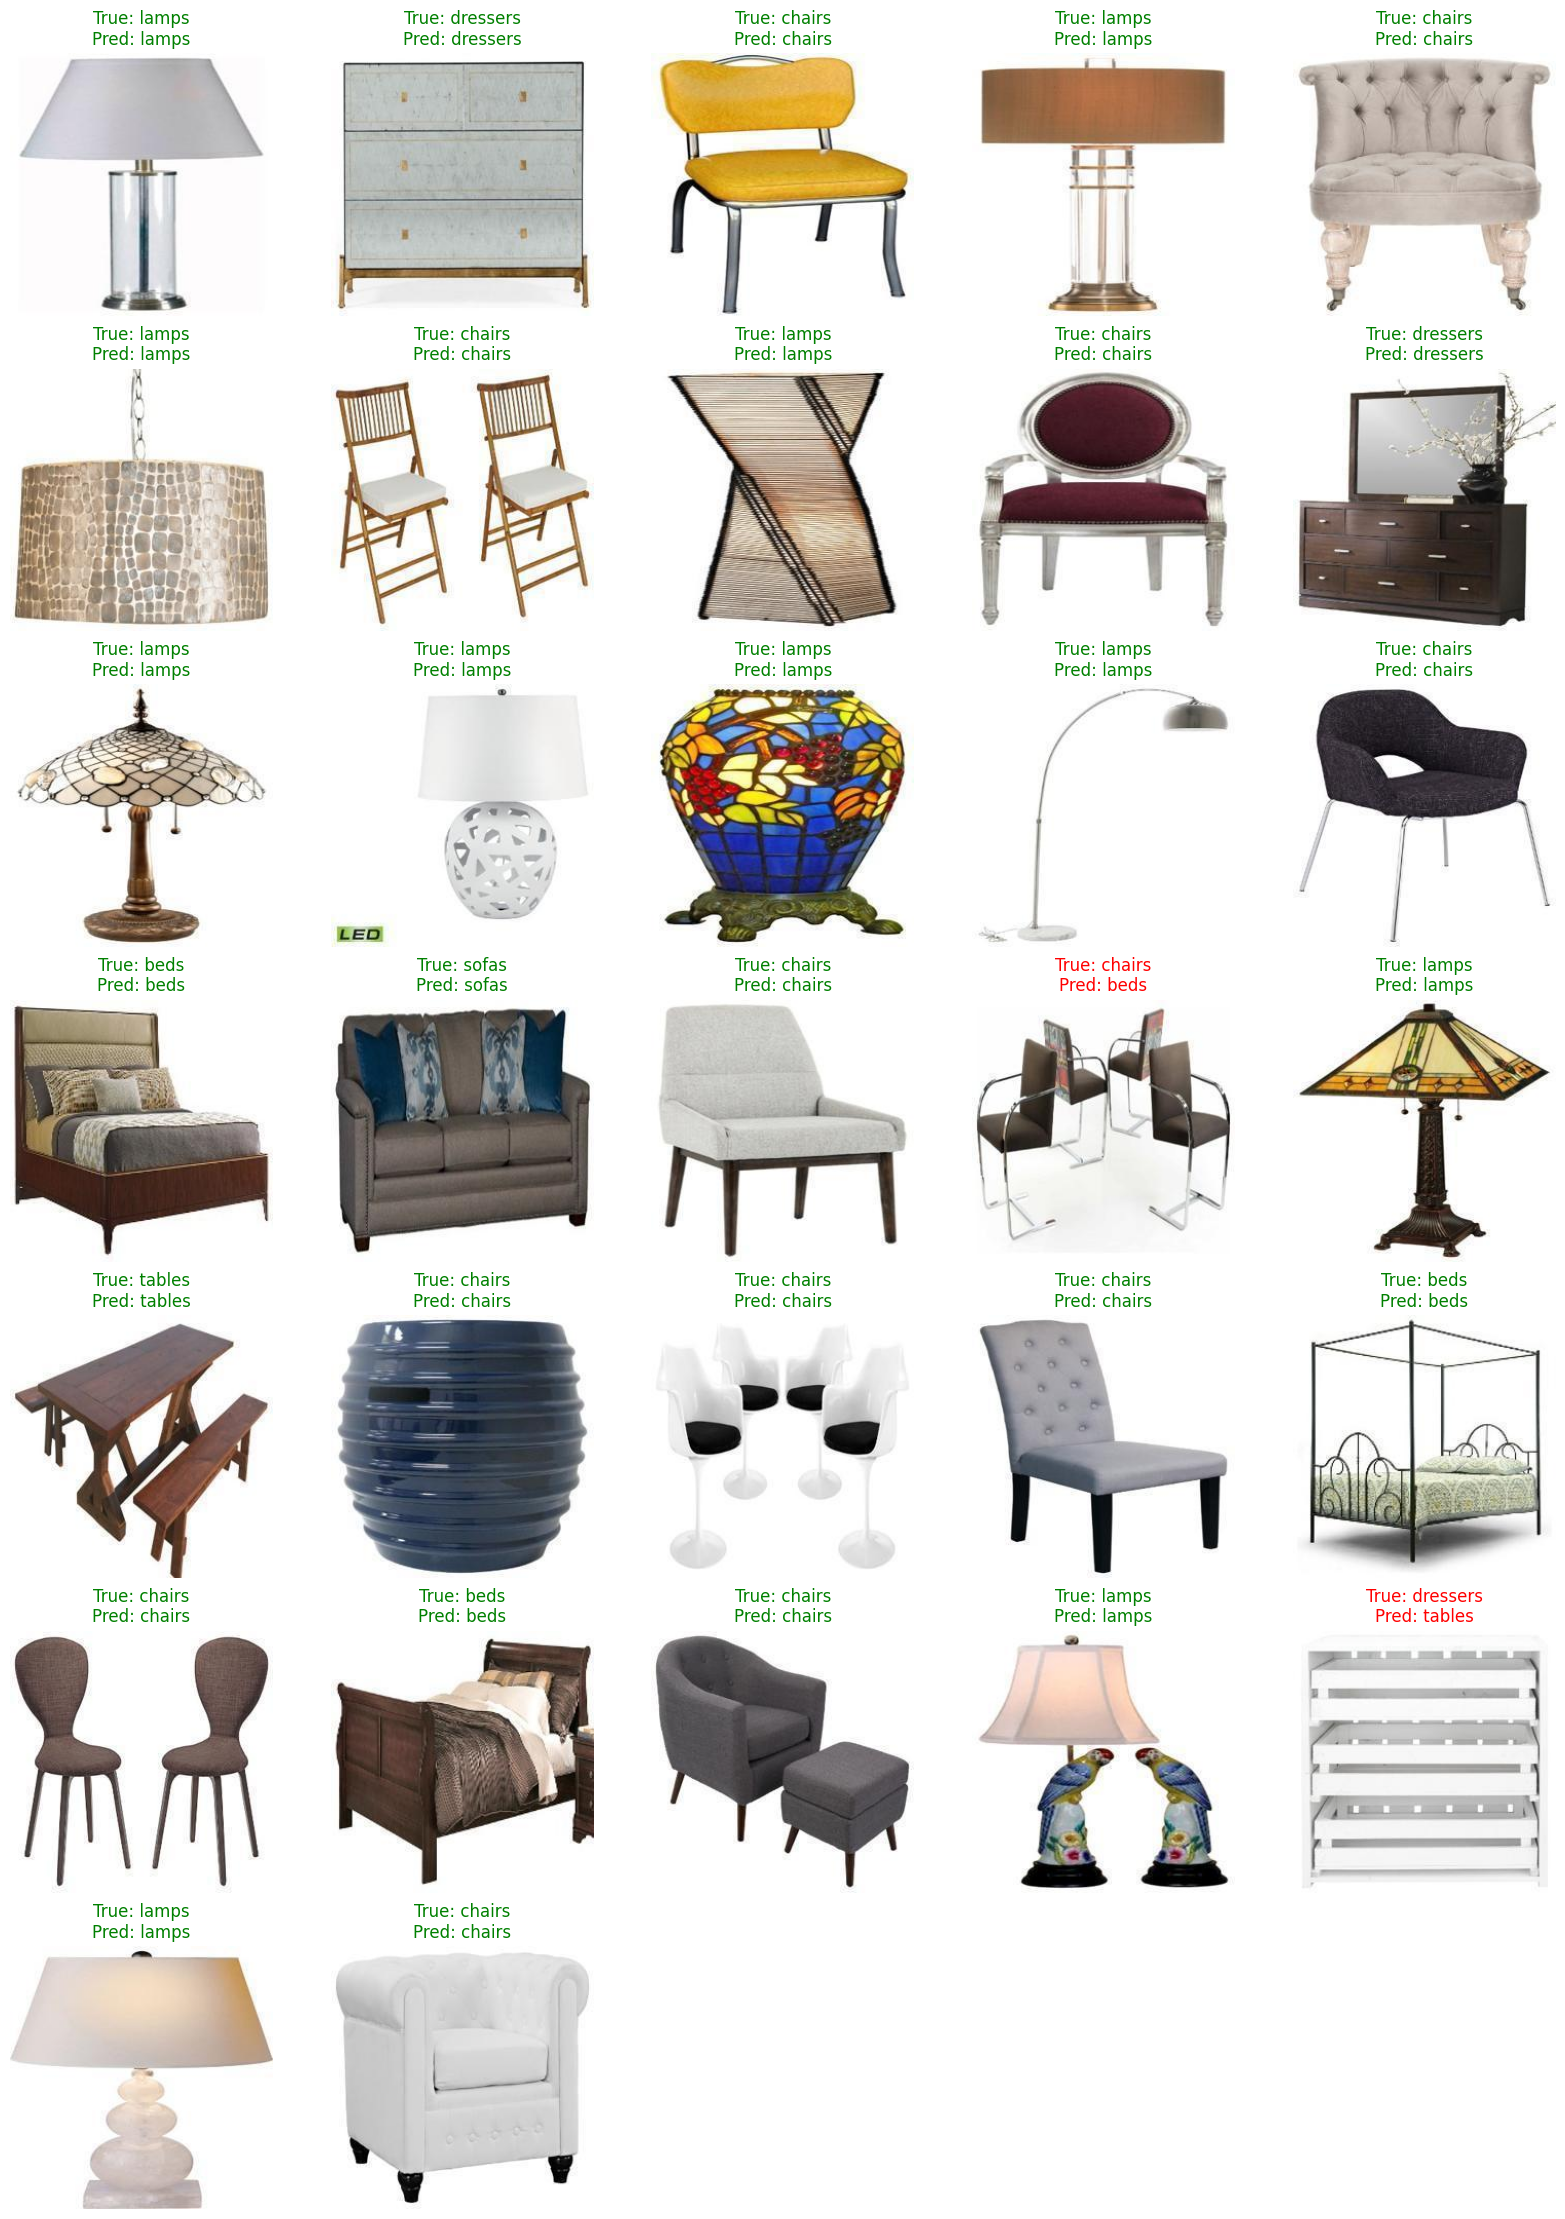

In [8]:
test_dataset = datagen.flow_from_dataframe(dataframe=df_test, shuffle=False, **common_args)

display_predictions(test_dataset, cnn, num_images=32)

# IV. Model Evaluation

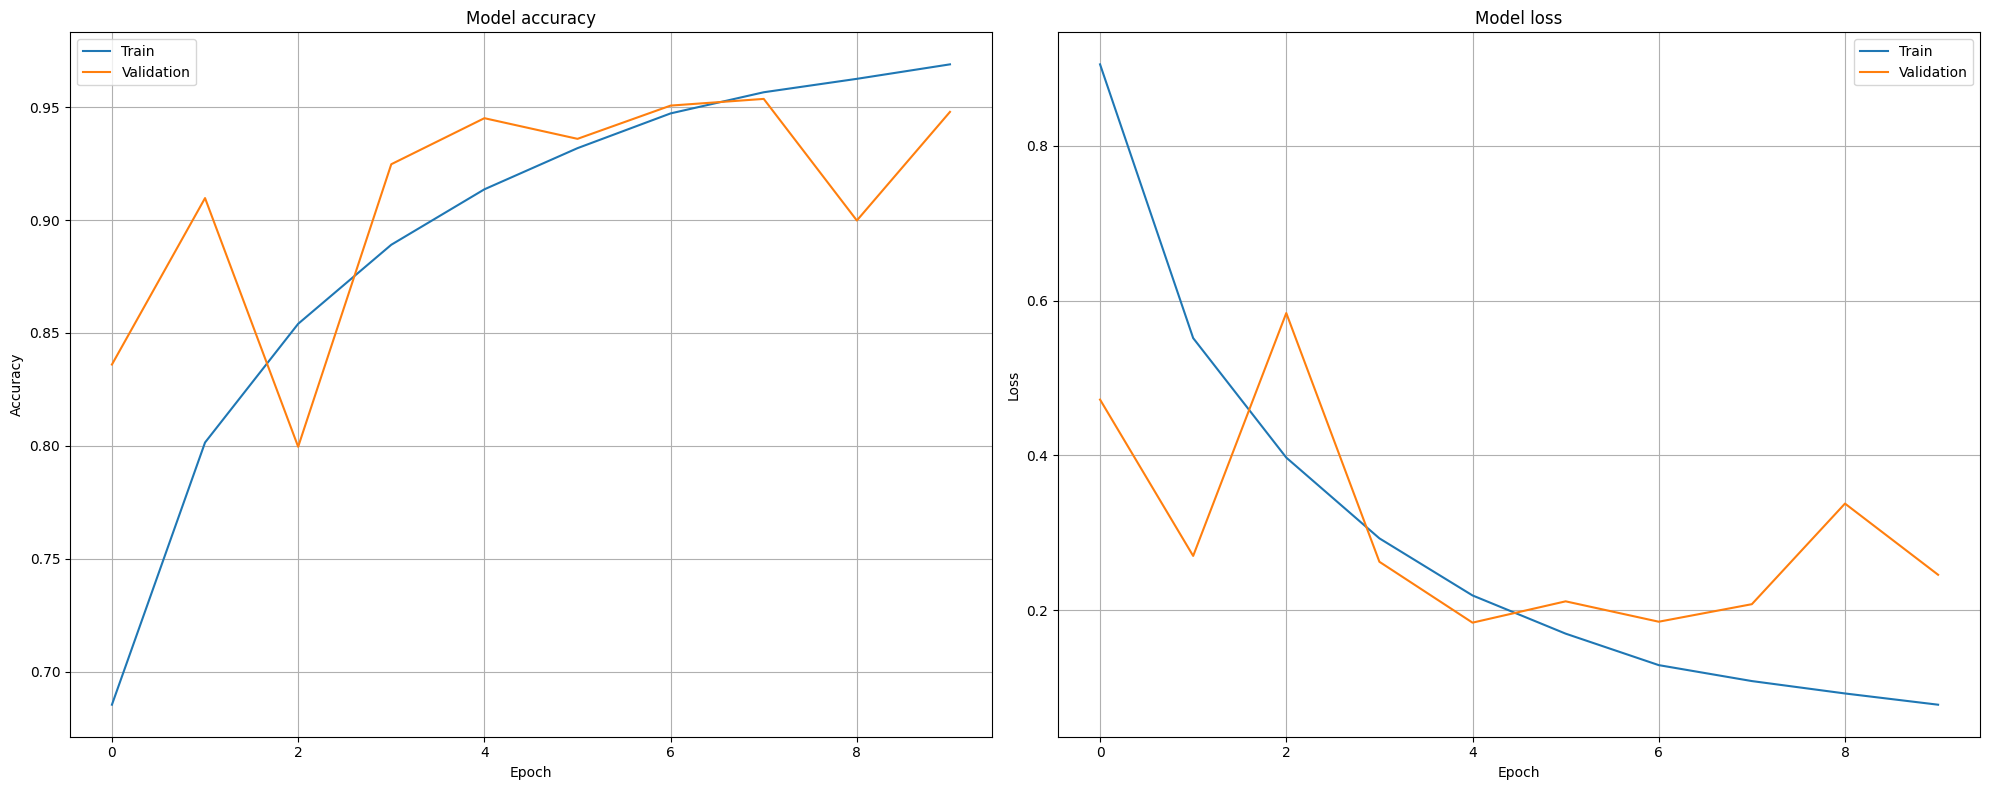

In [10]:
# load saved
saved_history = pd.read_csv("./cache_cnn/training.csv")  # Load training history

# Plot learning curves
def plot_learning_curves(history):
    plt.figure(figsize=(20, 8))  # Set the figure size
    plt.subplot(1, 2, 1)  # First subplot

    # Plot training & validation accuracy values
    plt.plot(history["accuracy"], label="Train")
    plt.plot(history["val_accuracy"], label="Validation")
    plt.title("Model accuracy")  # Title
    plt.ylabel("Accuracy")  # Y label
    plt.xlabel("Epoch")  # X label
    plt.legend()  # Show legend
    plt.grid()  # Show grid

    plt.subplot(1, 2, 2)  # Second subplot

    # Plot training & validation loss values
    plt.plot(history["loss"], label="Train")
    plt.plot(history["val_loss"], label="Validation")
    plt.title("Model loss")  # Title
    plt.ylabel("Loss")  # Y label
    plt.xlabel("Epoch")  # X label
    plt.legend()  # Show legend
    plt.grid()  # Show grid

    plt.tight_layout()  # Tight layout
    plt.show()  # Show plot


plot_learning_curves(saved_history)

In [8]:
# load saved model
cnn = tf.keras.models.load_model("./cache_cnn/cnn")  # Load model

cnn.summary()  # Model summary

# Evaluate model
loss, accuracy = cnn.evaluate(val_dataset, verbose=0)

print(f"Loss: {loss:.2f}")
print(f"Accuracy: {accuracy:.2f}")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 128, 128, 32)      128       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 128, 128, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 63, 63, 64)        0

2024-05-16 15:01:50.754340: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-05-16 15:01:51.342492: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-16 15:01:51.701682: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 646.01MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-16 15:01:51.922084: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 646.01MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-16 15:01:53.519513: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn 

Loss: 0.19
Accuracy: 0.95
